# Demonstration of how to use GPy to do model data comparison

I'll use this doc to demo the code, and find some initial results. Let's begin by loading the libraries we'll need.

In [1]:
import GPy
import sys
import os
sys.path.append(os.getenv("HOME") + "/Documents/Code/Emulation/GPyDifferentMetrics/")
from HaversineDist import Exponentialhaversine
import numpy as np
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib
import glob as glob
from cmocean import cm as cm
from Utilities import *


Now let's specify where the data and model runs are located, and load them.

In [2]:

GCM_dir = os.getenv("HOME")+'/Documents/Code/ModelDataComparison/DMC/Scripts/Model_data/CO2_anom/'
gcm_SSTs = glob.glob(GCM_dir+'t*.txt')

gcm_mask = np.genfromtxt(GCM_dir+'mask.txt', dtype='int')

obs_dir = os.getenv("HOME")+'/Documents/Code/ModelDataComparison/DMC/Scripts/Observation_data/P3+_SST_anom/'
file = 'lambda_10.txt'
observations = np.genfromtxt(obs_dir+file, skip_header=1)


We'll extract the observations into their coordinates (long and lat) which I'll refer to as X, the measurement (Y), and our estimate of the ratio of the variance of the measurement error at each point (NOTE: I was unsure whether the numbers in the data you gave me were supposed to standard deviations or variances - they look like std devs, so I've squared them). Note that all that matters is the relative size of these variances (their ratio). We need to try changing this to find its effect.

I've plotted the locations just as a check.

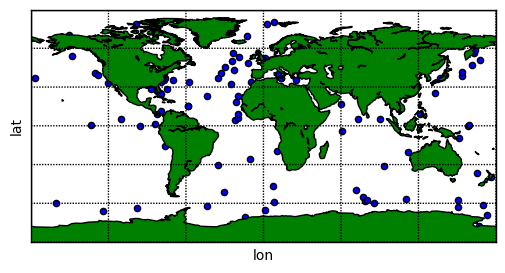

In [3]:
X_obs = observations[:,0:2]
y_obs = observations[:,2].reshape(-1,1)
var_ratios = observations[:,3][:,None]**2
map = plot_map(X_obs=X_obs)


## Fitting a Gaussian process model

Rather than use a GMRF to fit to the data, we will use a Gaussian process. This has the benefit of allowing us to use the extensive code base that has been developed over the past decade since GPs became prominent. They are also easier to understand, don't require as detailed knowledge to use, and are already widely used in the climate community as emulators. They do have some downsides which I'll discuss below.

We'll use the GPy software. This is widely seen to be the most complete and easiest to modify of the GP codes. It takes care of all the tricky numerical issues we face when using GPs. There is a large amount of training material online. It is in Python rather than R.

To begin with, *solely* for demonstration purposes, I'll use a standard GP (ignoring the fact we're on a sphere) just to demonstrate how simple the GPy code is. The basic steps we have to go through are
- specify a kernel/covariance function
- specify the model
- train the model

We achieve that with these three steps:

In [4]:
k = GPy.kern.Exponential(2, ARD=True)
m = GPy.models.GPRegression(X_obs, y_obs,k)
m.optimize_restarts(10)


Optimization restart 1/10, f = 199.85721787609538
Optimization restart 2/10, f = 199.8572178771054
Optimization restart 3/10, f = 229.563999714476
Optimization restart 4/10, f = 199.85721787818514
Optimization restart 5/10, f = 199.85721787625786
Optimization restart 6/10, f = 199.8572178890202
Optimization restart 7/10, f = 199.8572178782293
Optimization restart 8/10, f = 199.8572178764534
Optimization restart 9/10, f = 199.85721789268396
Optimization restart 10/10, f = 199.85721788025057


Now all we need to do is check the hyper-parameter estimates, and plot the model predictions. To do this, we need to specify a grid where we want to predict. I've used a 2.5 degree grid below - we can use something finer later.

In [5]:
print(m)
print(m.Exponential.lengthscale)



latsplot = np.arange(-90.0,90.0, 2.5)
longsplot = np.arange(-180.0,180.0, 2.5)
longgridplot, latgridplot = np.meshgrid(longsplot, latsplot)
X_plot=np.column_stack((longgridplot.flatten(), latgridplot.flatten())) # specifies the prediction locations

mu,V = m.predict_noiseless(X_plot)


Name : GP regression
Objective : 199.85721787609538
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |          value  |  constraints  |  priors
  Exponential.variance     |  15.0309441238  |      +ve      |        
  Exponential.lengthscale  |           (2,)  |      +ve      |        
  Gaussian_noise.variance  |  1.47133680706  |      +ve      |        
  index  |  GP_regression.Exponential.lengthscale  |  constraints  |  priors
  [0]    |                           253.13279707  |      +ve      |        
  [1]    |                           101.71296070  |      +ve      |        


 /Users/pmzrdw/Documents/Code/ModelDataComparison/PythonCode/Utilities.py:91: FutureWarning:comparison to `None` will result in an elementwise object comparison in the future.


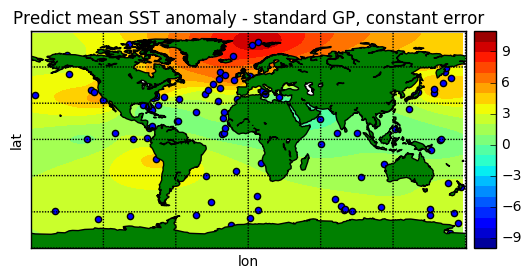

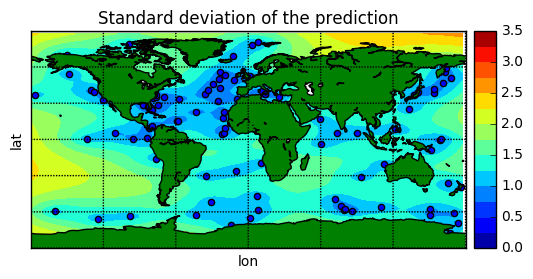

In [6]:

plt.figure(1)
map=plot_map(longgridplot, latgridplot, mu, X_obs)
plt.title('Predict mean SST anomaly - standard GP, constant error')

plt.figure(2)
map=plot_map(longgridplot, latgridplot, np.sqrt(V), X_obs, levels=np.arange(0,np.sqrt(V).max()+1,0.25))
plt.title('Standard deviation of the prediction')



There are a few comments to make about this. The first is that looking at the predicted mean (which is our best guess from the palaeo data of the SST anomaly), we can see that this is not realistic, as the patterns don't wrap around the globe, and there is too much variability at the north pole. This happens because we haven't told the GP that we are working on a sphere. We'll fix this in a moment.

The other comment is note that the prediction variance is small where we have data, and grows as we move away from the data. This is what we expect.

### GPs on spheres

Let's now tell the GP that we are modelling data on a sphere. To do this, we need to use the specially adapted covariance function that we've written. This is not part of the GPy distribution so we need to load it ourselves. I've called this Exponentialhaversine as it uses the Haversine distance to calculate the distance between two points on a sphere (NOTE: not on the globe), but is otherwise just a modification of the standard Exponential kernel.

The code we use to fit the model is exactly the same.

In [7]:

k2 = Exponentialhaversine(2, lengthscale=2000)
m2 = GPy.models.GPRegression(X_obs, y_obs,k2)
m2.optimize_restarts(10)


 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 200.49416801601154
Optimization restart 2/10, f = 256.5356747676507
Optimization restart 3/10, f = 256.5356565721887
Optimization restart 4/10, f = 256.53567442707407
Optimization restart 5/10, f = 256.53563983491125
Optimization restart 6/10, f = 256.5356717926791
Optimization restart 7/10, f = 256.5356711114765
Optimization restart 8/10, f = 256.5356606694669
Optimization restart 9/10, f = 256.5356747649861
Optimization restart 10/10, f = 256.53566790246066



Name : GP regression
Objective : 200.49416801601154
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |          value  |  constraints  |  priors
  Exponential.variance     |  8.84368108765  |      +ve      |        
  Exponential.lengthscale  |  5403.29426607  |      +ve      |        
  Gaussian_noise.variance  |  1.09844550332  |      +ve      |        

Name : GP regression
Objective : 200.49416801601154
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |          value  |  constraints  |  priors
  Exponential.variance     |  8.84368108765  |      +ve      |        
  Exponential.lengthscale  |  5403.29426607  |      +ve      |        
  Gaussian_noise.variance  |  1.09844550332  |      +ve      |        


 /Users/pmzrdw/Documents/Code/ModelDataComparison/PythonCode/Utilities.py:91: FutureWarning:comparison to `None` will result in an elementwise object comparison in the future.


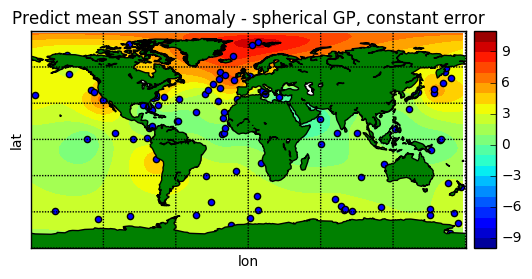

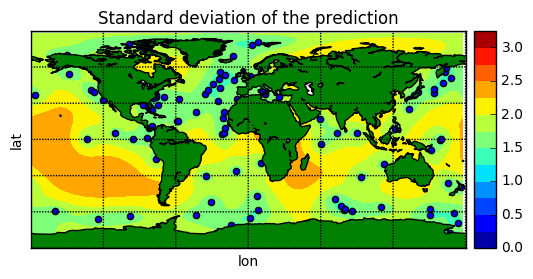

In [8]:
print(m2)
print(m2)
mu2,V2 = m2.predict(X_plot)

plt.figure(1)
map=plot_map(longgridplot, latgridplot, mu2, X_obs)
plt.title('Predict mean SST anomaly - spherical GP, constant error')

plt.figure(2)
map=plot_map(longgridplot, latgridplot, np.sqrt(V2), X_obs, levels=np.arange(0,np.sqrt(V2).max()+1,0.25))
plt.title('Standard deviation of the prediction')

This looks better. We now have a prediction that wraps around the globe (ie the same value at -180 and 180 longitude) and shrinks appropriately towards the poles. This plot looks very similar to those produces by Fran using Andrew's code (which is no surprise). I haven't managed to find the same colour map, and I've blacked out the continents, but the pattern over land looks very similar. 

A problem with this model is that it assumes the same measurement error at each point. We have written an extension to GPy that allows us to instead specify the measurement error.

### Heteroscedastic GPs

We've assumed that if

$$y = (y_1, \ldots, y_n$)$$
is our data vector, then 
$$ y = f(x) + \epsilon$$
where $f(x)$ is the underlying SST pattern, and $\epsilon$ is the measurement error. Above we used a homoscedastic model and assumed $\mathbb{V}\mbox{ar}(\epsilon) = \sigma^2 I$, i.e. a constant times the identity matrix. Now we'll use a heteroscedastic model and assume

$$\mathbb{V}\mbox{ar}(y) = \tau D$$
where $D$ is a diagonal matrix specifying the ratios of the measurement variances, and $\tau$ is a free parameter which scales the measurement errors all by the same amount. Note that this is slightly different to what Fran did with the GMRF code where the numbers are just fixed. We can also do this (see below).

To use the heteroscedastic model, we have to again load our own code in, and then simply change the GPy model we use. Everything else remains the same.

In [9]:

from scaledheteroscedasticgaussian import ScaledHeteroscedasticGaussian
from gp_heteroscedastic_ratios import ScaledHeteroscedasticRegression


k3 = Exponentialhaversine(2, lengthscale=2000)
m3 = ScaledHeteroscedasticRegression(X=X_obs, Y=y_obs, kernel=k3, noise_mult=1., 
                                     known_variances=var_ratios)
m3.optimize_restarts(10)


 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 202.7394228954263
Optimization restart 2/10, f = 230.29148806679066
Optimization restart 3/10, f = 256.53567582977985
Optimization restart 4/10, f = 256.5357009604168
Optimization restart 5/10, f = 230.29148806769004
Optimization restart 6/10, f = 230.29148807032226
Optimization restart 7/10, f = 256.5356785776253
Optimization restart 8/10, f = 230.29148847107206
Optimization restart 9/10, f = 256.5356750206566
Optimization restart 10/10, f = 230.29148806990128



Name : gp
Objective : 202.7394228954263
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                          |          value  |  constraints  |  priors
  Exponential.variance         |  9.72822417707  |      +ve      |        
  Exponential.lengthscale      |  4778.83030186  |      +ve      |        
  Scaled_het_Gauss.noise_mult  |  7.99632407141  |      +ve      |        


 /Users/pmzrdw/Documents/Code/ModelDataComparison/PythonCode/Utilities.py:91: FutureWarning:comparison to `None` will result in an elementwise object comparison in the future.


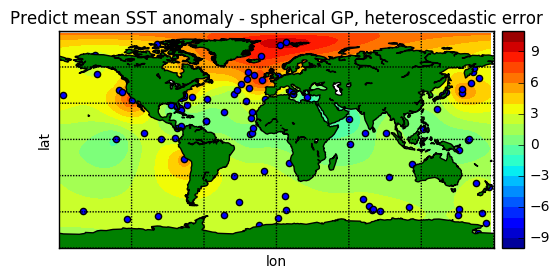

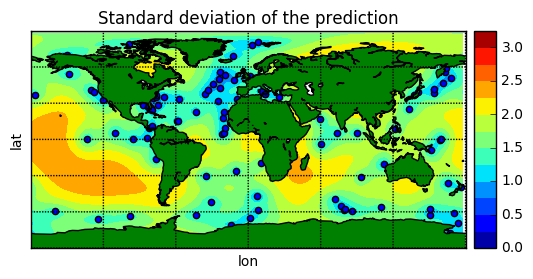

In [10]:
print(m3)

mu3,V3 = m3.predict_noiseless(X_plot)


plt.figure(3)
map=plot_map(longgridplot, latgridplot, mu3, X_obs)
plt.title('Predict mean SST anomaly - spherical GP, heteroscedastic error')

plt.figure(4)
map=plot_map(longgridplot, latgridplot, np.sqrt(V3), X_obs, levels=np.arange(0,np.sqrt(V3).max()+1,0.25))
plt.title('Standard deviation of the prediction')

If we look carefully, this has made some small difference to the predictions, but not much. If we try a different ratio, then we may or may not get different results. It looks though like the predictions are fairly robust to this choice - which is good!

In [11]:
file = 'lambda_100.txt'
observations = np.genfromtxt(obs_dir+file, skip_header=1)
var_ratios2 = observations[:,3][:,None]**2


k4 = Exponentialhaversine(2, lengthscale=2000)
m4 = ScaledHeteroscedasticRegression(X=X_obs, Y=y_obs, kernel=k4, noise_mult=1., 
                                     known_variances=var_ratios2)
m4.optimize_restarts(10)


 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 202.739422899165
Optimization restart 2/10, f = 230.29148806664725
Optimization restart 3/10, f = 230.29148806679655
Optimization restart 4/10, f = 230.29148806676443


 /Users/pmzrdw/GPy/GPy/kern/src/stationary.py:160: RuntimeWarning:overflow encountered in true_divide
 /Users/pmzrdw/GPy/GPy/kern/src/stationary.py:198: RuntimeWarning:invalid value encountered in multiply
 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/paramz/transformations.py:106: RuntimeWarning:invalid value encountered in greater
 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/paramz/transformations.py:111: RuntimeWarning:invalid value encountered in greater


Optimization restart 5/10, f = 230.69338038985595
Optimization restart 6/10, f = 230.29148806665538
Optimization restart 7/10, f = 256.5356755397257
Optimization restart 8/10, f = 256.5356798131834
Optimization restart 9/10, f = 230.29148806673462
Optimization restart 10/10, f = 256.53567528153815



Name : gp
Objective : 202.739422899165
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                          |            value  |  constraints  |  priors
  Exponential.variance         |    9.72846353257  |      +ve      |        
  Exponential.lengthscale      |    4779.01040669  |      +ve      |        
  Scaled_het_Gauss.noise_mult  |  0.0799643664688  |      +ve      |        


 /Users/pmzrdw/Documents/Code/ModelDataComparison/PythonCode/Utilities.py:91: FutureWarning:comparison to `None` will result in an elementwise object comparison in the future.


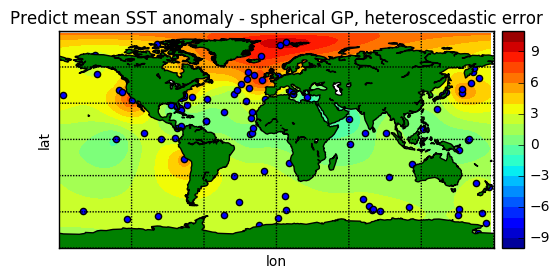

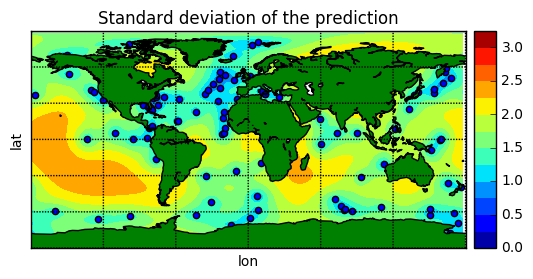

In [12]:
print(m4)

mu4,V4 = m4.predict_noiseless(X_plot)


plt.figure(3)
map=plot_map(longgridplot, latgridplot, mu4, X_obs)
plt.title('Predict mean SST anomaly - spherical GP, heteroscedastic error')

plt.figure(4)
map=plot_map(longgridplot, latgridplot, np.sqrt(V4), X_obs, levels=np.arange(0,np.sqrt(V4).max()+1,0.25))
plt.title('Standard deviation of the prediction')

A small caveat about these results are that I've had to use an isotropic kernel here (that is why I've left in the warning about not using ARD kernel's that prints out above). That means that the spatial dependence is the same in all directions. I can probably fix this, but its a bit of work so haven't done so yet. I suspect Andrew's code allowed us to use non-isotropic covariance structure (is that right Fran?)

The run time for each of the commands above is significantly less than a second. This I think would be much faster than the GMRF approach. Of course, if we have 1000s of data points, then this approach will be slower, and if we had 10,000s of data points then we'd have to use some approximate methods or revert to the GMRF approach.

Note the advantage of using GPy here. I can use all the built in functionality. If we want to fix the observation error, add a prior, use a sparse approximation, do MCMC etc, we can use the existing GPy code with no extra work. That is potentially very valuable.

For example, let's suppose we want to fix the measurement error to be 0.1 - this is easy using the built in functionality. This reduces the measurement error model to be exactly the same as Fran was using with Andrew's GMRF code.

In [13]:
k4 = Exponentialhaversine(2, lengthscale=2000)
m4 = ScaledHeteroscedasticRegression(X=X_obs, Y=y_obs, kernel=k4, noise_mult=1., 
                                     known_variances=var_ratios2)
m4.Scaled_het_Gauss.noise_mult.fix(0.1)

m4.optimize()
print(m4)




Name : gp
Objective : 202.93321470935857
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.                          |          value  |  constraints  |  priors
  Exponential.variance         |  9.67805289649  |      +ve      |        
  Exponential.lengthscale      |  5038.38954152  |      +ve      |        
  Scaled_het_Gauss.noise_mult  |            0.1  |   fixed +ve   |        


 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1


## Likelihood calculations

Let's now evaluate the 8 GCM simulations we have available. To do this, we need to predict the GCM output at every grid cell, and then evalaute the probability of seeing this value under our GP model fitted to the observational data.

We'll begin by loading the GCM runs

In [59]:
count=0
gcm_runs = np.zeros((8,27186))
gcm_runs_label = gcm_SSTs.copy()

for file_name in gcm_SSTs:
    file_nm = file_name.split(GCM_dir)[-1]
    print(file_nm)
    # Read in GCM output.
    gcm_runs[count,:] = np.genfromtxt(file_name)
    gcm_runs_label[count] = file_nm.split(".txt")[0]
    count +=1

    
# Create the prediction grid
X_pred, out = ThinGrid(gcm_runs[0,:], gcm_mask, thinby=1)

tczyi.txt
tczyj.txt
tczyk.txt
tdgtg.txt
tdgth.txt
tdgti.txt
tdgtj.txt
tdgtk.txt


I've written a custom density function (checked against scipy) that takes the cholesky decomposition of the covariance matrix. This means we only need to compute it once for any given resolution (note if the GP changes we'd have to recompute). Let's predict with the GP on each grid, and then compute the cholesky decomposition of the covariance matrix. This is slow - it takes ~4 minutes to do the Cholesky decomposition for the full grid on my laptop(2.2 Ghz Intel i7, wigh 16GB memory). My desktop machine won't calculate this, due to lack of memory.

In [15]:
mu, Cov = m3.predict_noiseless(X_pred, full_cov=True)
Chol = np.linalg.cholesky(Cov)

In [17]:
from Cholesky import *
loglikes = dlogmvnorm(gcm_runs.T, mu, Chol)
orderings = np.argsort(-loglikes) #minus sign so that max is first
relative = np.round(loglikes-np.max(loglikes),1)

In [75]:
print(loglikes)
print(relative)
for ii in gcm_runs_label:
    print(dict[ii], end=',\t')
orderings


[ -6816.15966424  -7098.9983753   -7807.38607498  -7406.49459638
  -6659.75880127 -10610.11020693  -6989.55283844  -8104.99549526]
[ -156.4  -439.2 -1147.6  -746.7     0.  -3950.4  -329.8 -1445.2]
315 ppm,	375 ppm,	475 ppm,	405 ppm,	280 ppm,	1000 ppm,	350 ppm,	560 ppm,	

array([4, 0, 6, 1, 3, 2, 7, 5])

The orderings vector indicates which item was best. Orderings[0]=4, which means the 5th (as Python indexes from 0) GCM run in our list had the largest log-likelihood.

We can decode from the file names to the CO2 values to this to see how this ranks the various GCM runs.

In [47]:
dict = {'tdgth': '280 ppm',
        'tczyi': '315 ppm',
    'tdgtj': '350 ppm',
    'tczyj': '375 ppm',
    'tdgtg': '405 ppm',
    'tczyk': '475 ppm',
    'tdgtk': '560 ppm',
    'tdgti': '1000 ppm'}

for ii in range(8):
    print(dict[gcm_runs_label[orderings[ii]]] + ':  relative loglike = '+str(relative[orderings[ii]]))

280 ppm:  relative loglike = 0.0
315 ppm:  relative loglike = -156.4
350 ppm:  relative loglike = -329.8
375 ppm:  relative loglike = -439.2
405 ppm:  relative loglike = -746.7
475 ppm:  relative loglike = -1147.6
560 ppm:  relative loglike = -1445.2
1000 ppm:  relative loglike = -3950.4


Let's plot the GCM runs in order of their log-likelihood ranking.

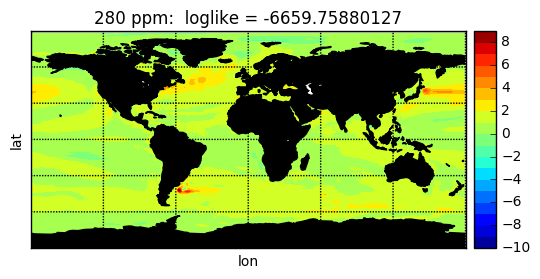

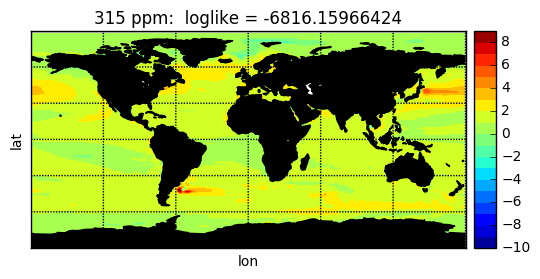

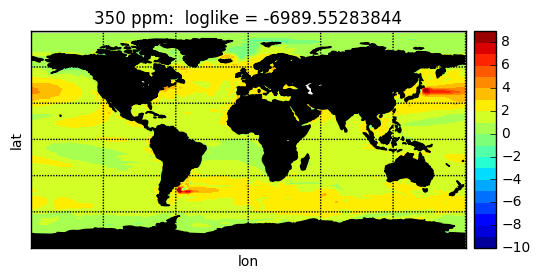

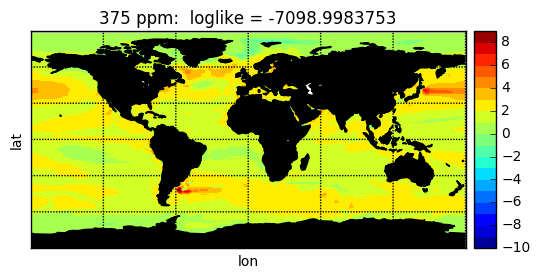

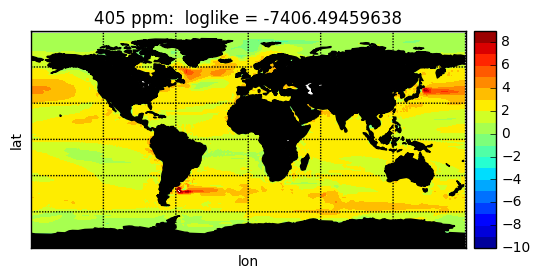

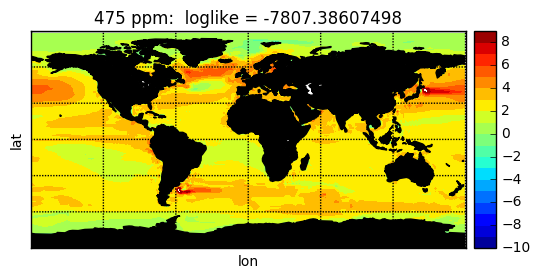

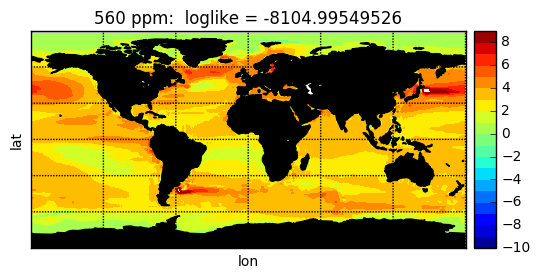

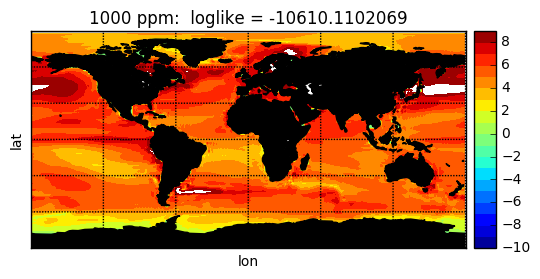

In [53]:
for ii in range(8):
    plt.figure()
    map = plot_gcm(gcm_runs[orderings[ii],:], gcm_mask)
    plt.title(dict[gcm_runs_label[orderings[ii]]]+ ':  loglike = '+ str(loglikes[orderings[ii]]))
#    plt.title(loglikes[ii]+': log-likelihood = ' + str(round(float(loglike_results[ii,0]),1)))



Note that the uncertainty in our predictions (i.e. the how the matrix Cov is defined), is that it is the uncertainty in the underlying function. There is no measurement error component here. We may want to think about whether we need to add more noise in or not.

We can also compute the log-likelihood for other values. The best possible value achievable is using the GP mean surface. 
  

In [50]:
dlogmvnorm(mu, mu, Chol)

array([-4456.97018611])


### Thinning the grid

Because the GCM data is on a fine grid (with 27000 values over ocean), this is difficult to work with (we can do so as above - but only if your computer has at least 16GB of RAM). So we can thin the grid to only predict nth value.  Be warned (and see the Likelihood notebook), this can change the ordering of the models if we thin too much.



In [71]:
thinby=2
X_pred2, out = ThinGrid(gcm_runs[0,:], gcm_mask, thinby=thinby)
gcm_thin = np.zeros((8, out.size))

for count in range(8):
    X_pred, out = ThinGrid(gcm_runs[count,:], gcm_mask, thinby=thinby)
    gcm_thin[count,:] = out.flatten()
   
mu2, Cov2 = m3.predict_noiseless(X_pred2, full_cov=True)
Chol2 = np.linalg.cholesky(Cov2)

loglikes2 = dlogmvnorm(gcm_thin.T, mu2, Chol2)
orderings2 = np.argsort(-loglikes2) #minus sign so that max is first
relative2 = np.round(loglikes2-np.max(loglikes2),1)

In [76]:
for ii in range(8):
    print(dict[gcm_runs_label[orderings2[ii]]] + ':  relative loglike = '+str(relative2[orderings2[ii]]))

280 ppm:  relative loglike = 0.0
315 ppm:  relative loglike = -57.8
350 ppm:  relative loglike = -79.5
375 ppm:  relative loglike = -82.2
405 ppm:  relative loglike = -96.2
475 ppm:  relative loglike = -195.1
560 ppm:  relative loglike = -272.9
1000 ppm:  relative loglike = -1305.9


So we can see that thinning by a factor of two (both the longitude and latitude grid), does not change the ordering at all.

### Comparison with the RMSE
We can compare the ranking of the GCM simulations obtained using the log-likelihood as a scoring rule with the ranking obtained using a naive implementation of the RMSE. Here, I have found the nearest grid point to each observation (using the Haversine distance), and then assumed that was the GCM prediction.

In [133]:

def MSE(X_obs, X_pred, y_obs, gcm_out):
    k = Exponentialhaversine(2)
    index = np.argmin(k._unscaled_dist(X_obs, X_pred), axis=1)
    #print(k._unscaled_dist(X_obs, X_pred)[range(y_obs.size),index])
    y_gcm_grid = gcm_out[index]
    return(np.sqrt(np.mean((y_gcm_grid-y_obs)**2)))    

In [134]:
X_pred, out = ThinGrid(gcm_runs[0,:], gcm_mask, thinby=1)


MSEs = np.zeros(8)
for ii in range(8):
    MSEs[ii]=(MSE(X_obs, X_pred, y_obs, gcm_runs[ii,:]))
MSEorderings = np.argsort(MSEs)
print(MSEorderings)

[3 1 6 2 0 4 7 5]


In [135]:
for ii in range(8):
    print(dict[gcm_runs_label[MSEorderings[ii]]] + ':  RMSE = ' + str(MSEs[orderings[ii]]))

405 ppm:  RMSE = 2.92887357707
375 ppm:  RMSE = 2.82330773515
350 ppm:  RMSE = 2.753603104
475 ppm:  RMSE = 2.73839069283
315 ppm:  RMSE = 2.70388084115
280 ppm:  RMSE = 2.76910802861
560 ppm:  RMSE = 2.92941172431
1000 ppm:  RMSE = 4.62599374426


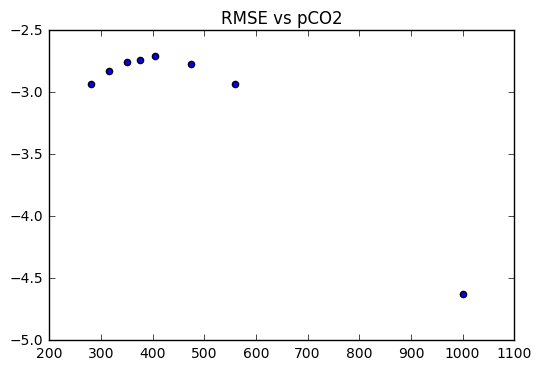

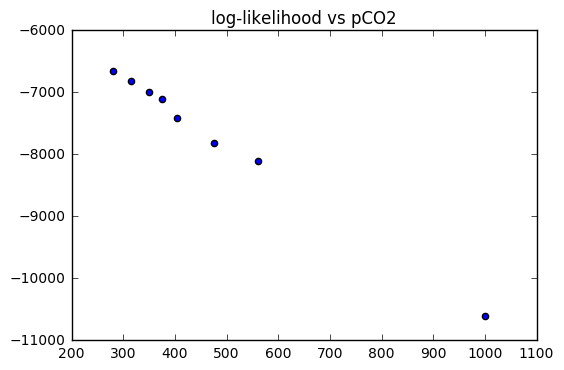

In [137]:
CO2 = np.zeros(8)
for ii in range(8):
    CO2[ii] = int(dict[gcm_runs_label[ii]].split(' ppm')[0])
    
plt.scatter(CO2, -MSEs)

plt.title('RMSE vs pCO2')
plt.figure()
plt.scatter(CO2, loglikes)
plt.title('log-likelihood vs pCO2')

So interestingly we're getting different rankings from the log-likelihood and the RMSEs. In a sense, this is what we hoped for. Here, the data are telling us smaller pCO2s are sensible. The RMSE tells us pCO2$\approx 450$ppm is best. 

Curiously, our RMSE results don't match Fran's RMSE results. This may be because I'm using a daft pairing of data and simulation.